In [1]:
import torch
import torch.optim as optim
import numpy as np
from flows_utils import *
from training_utils import *
from plot_utils import *
from sampling_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [2]:

def constraint_learning(paras):
    simple_set = paras['init_shape']
    constraints = paras['constraint']
    distortion = paras['distortion_coefficient']
    instance_file = f'models/toy_example_{simple_set}_{constraints.__class__.__name__}/distortion_{distortion}'
    #### Input-Output Specification: (t->x)
    n_dim = 2
    t_dim = constraints.t_dim
    #### Flow-based model: sphere -> constraint set
    num_layer = paras['num_layer']
    modules = []
    for l in range(num_layer):
        modules += [ActNorm(num_inputs=n_dim),
                    LUInvertibleMM(num_inputs=n_dim),
                    ActNorm(num_inputs=n_dim),
                    MADE(num_inputs=n_dim, num_hidden=32, num_cond_inputs=t_dim)]
    modules.append(ActNorm(num_inputs=n_dim))
    model = INN(modules).to(device=device)
    if not os.path.exists(instance_file):
        os.mkdir(instance_file)

    #### Sampling input parameters and output decision
    n_samples = paras['n_samples']
    t_samples = paras['t_samples']
    x_train = sampling_body(n_samples, n_dim, simple_set)  # + bias
    t_train = np.random.uniform(low=constraints.sampling_range[0], high=constraints.sampling_range[1],
                                size=[t_samples, t_dim])
    x_train_tensor = torch.tensor(x_train).view(-1, n_dim).to(device=device)
    t_train_tensor = torch.tensor(t_train).view(-1, t_dim).to(device=device)
    optimizer = optim.Adam(model.parameters(), lr=paras['lr'], weight_decay=1e-6)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=paras['lr_decay_step'], gamma=paras['lr_decay'])
    #### Unsupervised Training for Hemo Mapping
    model, volume_list, penalty_list, dist_list, trans_list = training(model, constraints, optimizer, scheduler,
                                                                       x_train_tensor, t_train_tensor, paras)
    torch.save(model, instance_file + '/model.pth')
    np.save(instance_file + '/records.npy', [volume_list, penalty_list, dist_list, trans_list])

In [3]:
paras = {'init_shape': 'sphere',
             'seed': 2002,
             'constraint': Complex_Constraints(),
             'bound': [-1,1],
             'scale_ratio': 1.,
             'n_samples': 1024,
             't_samples': 10000,
             'total_iteration': 10000,
             'batch_size': 512,
             'num_layer': 3,
             'lr': 5e-3,
             'lr_decay': 0.9,
             'lr_decay_step': 1000,
             'penalty_coefficient': 50,
             'distortion_coefficient': 0.5,
             'transport_coefficient': 0.0,}
constraint_learning(paras)

Iteration: 1000/10000, Volume: -0.3591, Penalty: 0.0037, Distortion: 0.1564, Transport: 0.5104, Valid: 0.00000000
Iteration: 2000/10000, Volume: -0.3597, Penalty: 0.0019, Distortion: 0.1643, Transport: 0.5105, Valid: 0.00011352
Iteration: 3000/10000, Volume: -0.3264, Penalty: 0.0026, Distortion: 0.1444, Transport: 0.5233, Valid: 0.00000000
Iteration: 4000/10000, Volume: -0.3706, Penalty: 0.0014, Distortion: 0.1496, Transport: 0.4961, Valid: 0.00000000
Iteration: 5000/10000, Volume: -0.3557, Penalty: 0.0018, Distortion: 0.1485, Transport: 0.5553, Valid: 0.00000000
Iteration: 6000/10000, Volume: -0.3633, Penalty: 0.0019, Distortion: 0.1662, Transport: 0.5209, Valid: 0.00000000
Iteration: 7000/10000, Volume: -0.2985, Penalty: 0.0010, Distortion: 0.1544, Transport: 0.5673, Valid: 0.00000000
Iteration: 8000/10000, Volume: -0.3449, Penalty: 0.0012, Distortion: 0.1464, Transport: 0.5153, Valid: 0.00000000
Iteration: 9000/10000, Volume: -0.3471, Penalty: 0.0014, Distortion: 0.1408, Transport: 

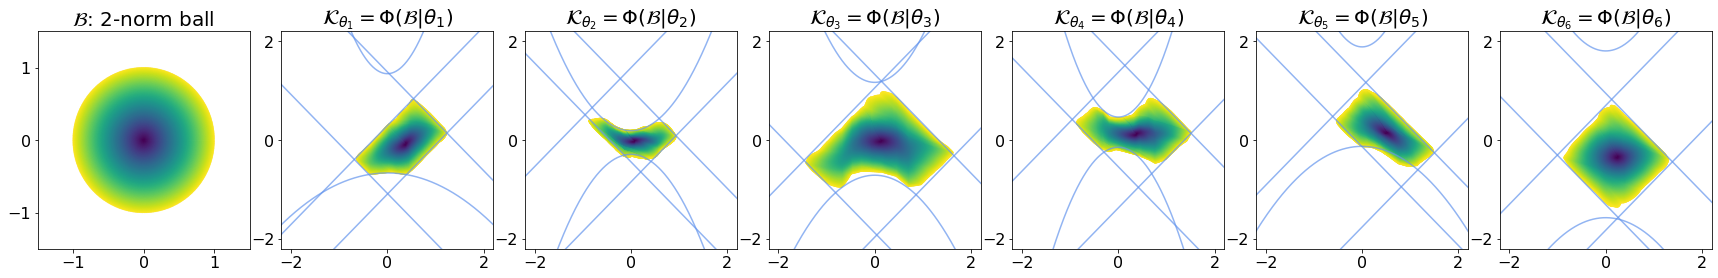

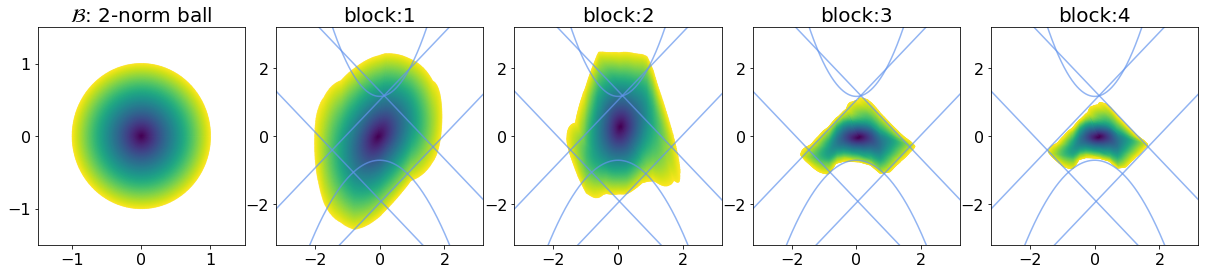

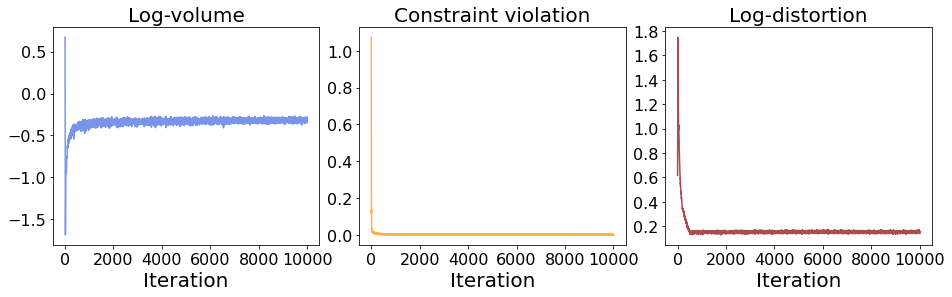

In [5]:
#### Ploting results
simple_set = paras['init_shape']
constraints = paras['constraint']
distortion = paras['distortion_coefficient']
instance_file = f'models/toy_example_{simple_set}_{constraints.__class__.__name__}/distortion_{distortion}'
n_dim = 2
x_train = sampling_body(100000, n_dim, simple_set)
x_train_tensor = torch.tensor(x_train).view(-1, n_dim).to(device=device)
model = torch.load(instance_file + '/model.pth')
volume_list, penalty_list, dist_list, trans_list = np.load(instance_file + '/records.npy')
np.random.seed(paras['seed'])
constraints.t_test = np.random.uniform(low=constraints.sampling_range[0],
                                        high=constraints.sampling_range[1],
                                        size=[6, constraints.t_dim])
scatter_constraint_approximation(model, constraints, x_train_tensor, simple_set, instance_file, paras)
scatter_constraint_evolution(model, constraints, x_train_tensor, simple_set, instance_file, paras)
plot_convergence(volume_list, penalty_list, dist_list, trans_list, instance_file)